# Evolution of Utility Fuel & Generation Over Time
This notebook attempts to explore how a utility's operations evolve over time, including:

* How has their fuel mix changed over time (Coal, Gas, Hydro, Wind, Solar)?
* How has generation by type of plant changed over time (CCGT, CT, Steam Turbine, etc.)?
* How have the capacity factors of the utility's plants changed over time?
* How has the total amount of electricity generated by plant changed over time?

The notebook primarily draws from the EIA923 data, but we will pull in some FERC Form 1 annual data for comparison with the EIA923 on an annualized basis.  How similar are they?

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
from pudl import clean_eia923, clean_ferc1, clean_pudl
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
%matplotlib inline

pudl_engine = pudl.db_connect_pudl()
ferc1_engine = ferc1.db_connect_ferc1()

## Given a utility, generate a list of all its associated plants.
Before we can explore how a utility's generation mix and fuel usage has changed over time, we need to figure out which power plants are associated with it.

* Given an EIA operator_id (or a FERC respondent_id), we need to find the PUDL utility_id
* Then we can look up all of the PUDL plant_id values associated with that utility_id
* Finally we look up up all of the EIA 923 plant_id values associated with those PUDL plant_ids

In [2]:
def eia_operator_plants(operator_id):
    Session = sa.orm.sessionmaker()
    Session.configure(bind = pudl_engine)
    session = Session()
    pudl_plant_ids = [ p.plant_id for p in session.query(models.UtilityEIA923).\
                                              filter_by(operator_id=operator_id).\
                                              first().util_pudl.plants ]
    eia923_plant_ids = [ p.plant_id for p in session.query(models.PlantEIA923).\
                                                filter(models.PlantEIA923.plant_id_pudl.in_(pudl_plant_ids)) ]
    session.close_all()
    return(eia923_plant_ids)

## Select fuel & generation data based on that list of plants.
Rather than pulling millions of unrelated records into dataframes, let's just grab the records that are related to the list of plants that we know are associated with the utility we're interested in.  In this case, we're going to explore Ameren, a utility in Missouri, which has EIA `operator_id = 19436`

In [3]:
# Ameren (aka Union Electric Company of Missouri)
#target_eia923_operator_id = 19436
# Xcel Colorado (aka Public Service Company of Colorado)
target_eia923_operator_id = 15466
# PacifiCorp
#target_eia923_operator_id = 14354
n_plants = 5

## Organizing the data to make some plots...
First, let's pull all the EIA923 records for plants that are related to the utility we are investigating.

In [4]:
Session = sa.orm.sessionmaker()
Session.configure(bind = pudl_engine)
session = Session()

# Use the above defined function to grab the Ameren plant_id list:
target_eia923_plant_ids = eia_operator_plants(target_eia923_operator_id)
target_eia923_utility_name = session.query(models.UtilityEIA923).\
                                           filter_by(operator_id=target_eia923_operator_id).\
                                           first().operator_name

# Now grab records related to those plants from plant_info, generation_fuel, generation, and fuel_receipts_costs
pi_tbl = models.PUDLBase.metadata.tables['plant_info_eia923']
plants_eia923_tbl = models.PUDLBase.metadata.tables['plants_eia923']

# Let's pull in the plant_name field as well so we know what we're looking at:
pi_select = sa.sql.select([pi_tbl.c.plant_id,
                           plants_eia923_tbl.c.plant_name,
                           pi_tbl.c.plant_state,
                           pi_tbl.c.nameplate_capacity_mw]).\
                          where(pi_tbl.c.plant_id.in_(target_eia923_plant_ids)).\
                          where(pi_tbl.c.plant_id == plants_eia923_tbl.c.plant_id)

pi_df = pd.read_sql(pi_select, pudl_engine)

gf_tbl = models.PUDLBase.metadata.tables['generation_fuel_eia923']
gf_select = sa.sql.select([gf_tbl,]).where(gf_tbl.c.plant_id.in_(target_eia923_plant_ids))
gf_df = pd.read_sql(gf_select, pudl_engine)
gf_df = gf_df.merge(pi_df, on='plant_id')
gf_df.drop('id', axis=1, inplace=True)
gf_df['report_date'] = pd.to_datetime(gf_df['report_date'])
gf_df.index = gf_df['report_date']

g_tbl = models.PUDLBase.metadata.tables['generation_eia923']
g_select = sa.sql.select([g_tbl,]).where(g_tbl.c.plant_id.in_(target_eia923_plant_ids))
g_df = pd.read_sql(g_select, pudl_engine)
g_df = g_df.merge(pi_df, on='plant_id')
g_df.drop('id', axis=1, inplace=True)
g_df['report_date'] = pd.to_datetime(g_df['report_date'])
g_df.index = g_df['report_date']

frc_tbl = models.PUDLBase.metadata.tables['fuel_receipts_costs_eia923']
frc_select = sa.sql.select([frc_tbl,]).where(frc_tbl.c.plant_id.in_(target_eia923_plant_ids))
frc_df = pd.read_sql(frc_select, pudl_engine)
frc_df = frc_df.merge(pi_df, on='plant_id')
frc_df.drop('fuel_receipt_id', axis=1, inplace=True)
frc_df['report_date'] = pd.to_datetime(frc_df['report_date'])
frc_df.index = frc_df['report_date']

session.close_all()

## Plotting one variable on a per plant basis
This routine takes all of the records we've pulled for a utility's plants, and groups it by plant and by month, so that we can chart how a given field has changed over the entire time that we have EIA923 data for.

In [5]:
def plot_byplant(df, coltoplot, title='', ylabel='', n=n_plants):
    plants_sorted = df[['plant_id','plant_name','nameplate_capacity_mw']].\
                       drop_duplicates(subset=['plant_id',]).\
                       sort_values(by='nameplate_capacity_mw', ascending=False)
    df_byplant = df.groupby(['plant_id', pd.TimeGrouper(freq='M')])
    
    fig, axarr = plt.subplots(len(plants_sorted[:n]), dpi=100)
    fig.set_figwidth(10)
    fig.set_figheight(6*len(plants_sorted[:n]))
    
    for plant_id, plant_name, ax in zip(plants_sorted.plant_id[:n], plants_sorted.plant_name[:n], axarr):
        ax.plot(df_byplant[coltoplot].sum()[plant_id], label=plant_name, lw=2)
        ax.grid()
        ax.set_xlabel("Year")
        ax.set_ylabel(ylabel)
        ax.set_title(title+" for {} Plants".format(target_eia923_utility_name))
        legend = ax.legend()

## Plotting plant capacity factors
Capacity factor isn't listed as an independent variable -- we have to calculate it based on the amount of power a plant generates, and it's nameplate (maximum) capacity. This routine groups output by month and by plant, and divides by the calculated maximum monthly output.

In [6]:
def plot_byplant_capfac(df, coltoplot, title='', ylabel='', n=n_plants):
    plants_sorted = df[['plant_id','plant_name','nameplate_capacity_mw']].\
                       drop_duplicates(subset=['plant_id',]).\
                       sort_values(by='nameplate_capacity_mw', ascending=False)
    df_byplant = df.groupby(['plant_id', pd.TimeGrouper(freq='M')])
    
    fig, axarr = plt.subplots(len(plants_sorted[:n]), dpi=100)
    fig.set_figwidth(10)
    fig.set_figheight(6*len(plants_sorted[:n]))
   
    for plant_id, plant_name, ax in zip(plants_sorted.plant_id[:n], plants_sorted.plant_name[:n], axarr):
        nameplate_capacity_mw = pi_df[pi_df['plant_id']==plant_id]['nameplate_capacity_mw'].values[0]
        maxgen_monthly = nameplate_capacity_mw*(8760/12)
        ax.plot(df_byplant[coltoplot].sum()[plant_id]/maxgen_monthly, label=plant_name, lw=2)
        ax.grid()
        ax.set_xlabel("Year")
        ax.set_ylabel(ylabel)
        ax.set_title(title+" for {} Plants".format(target_eia923_utility_name))
        legend = ax.legend()

## Per Plant Capacity Factor Based on Generation Fuel Data

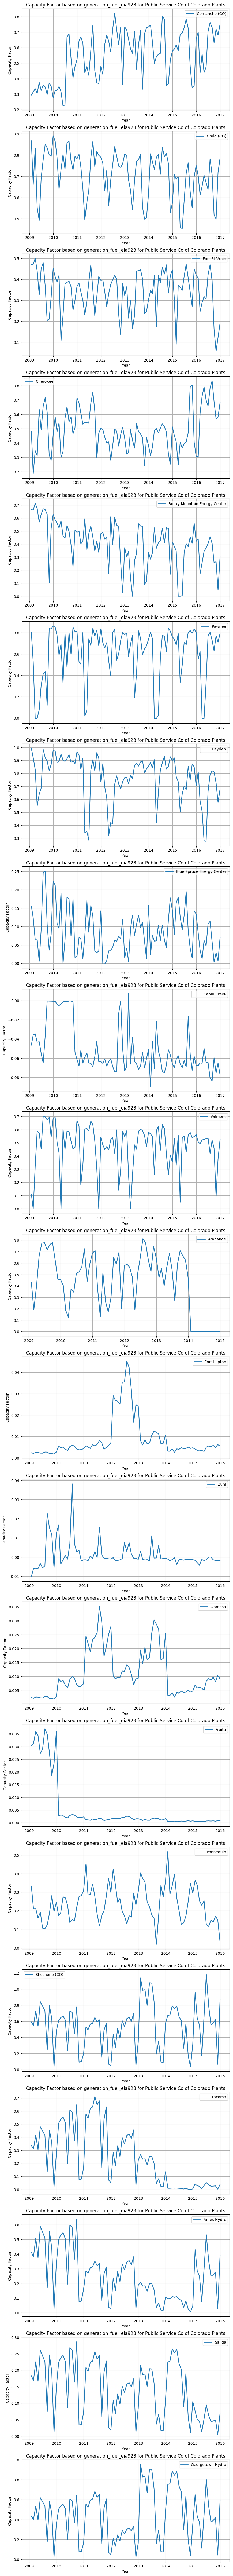

In [7]:
plot_byplant_capfac(gf_df, 'net_generation_mwh',
                    title="Capacity Factor based on generation_fuel_eia923",
                    ylabel='Capacity Factor', n=21) 

## Generation by fuel type over time.
This let's us look at how a given utility's generation mix has evolved over time, in terms of how much electricity is generated from various fuels.

In [8]:
gf_df.columns

Index(['plant_id', 'report_date', 'nuclear_unit_id', 'fuel_type',
       'aer_fuel_type', 'aer_fuel_category', 'prime_mover',
       'fuel_consumed_total', 'fuel_consumed_for_electricity',
       'fuel_mmbtu_per_unit', 'fuel_consumed_total_mmbtu',
       'fuel_consumed_for_electricity_mmbtu', 'net_generation_mwh',
       'plant_name', 'plant_state', 'nameplate_capacity_mw'],
      dtype='object')

In [9]:
def plot_genmix(df):
    df2 = df[['aer_fuel_category', 'report_date', 'net_generation_mwh']]
    df_byfuel = df2.groupby(['aer_fuel_category', pd.TimeGrouper(freq='M')])
    fig, (ax) = plt.subplots(1, dpi=100)
    fig.set_figwidth(10)
    fig.set_figheight(6)
    ax.set_xlabel("Year")
    ax.set_ylabel("Total Generation (MWh)")
    ax.set_title("Dude!")
    ax.grid()
    
    ax.plot(df_byfuel['net_generation_mwh'].sum()['coal'])

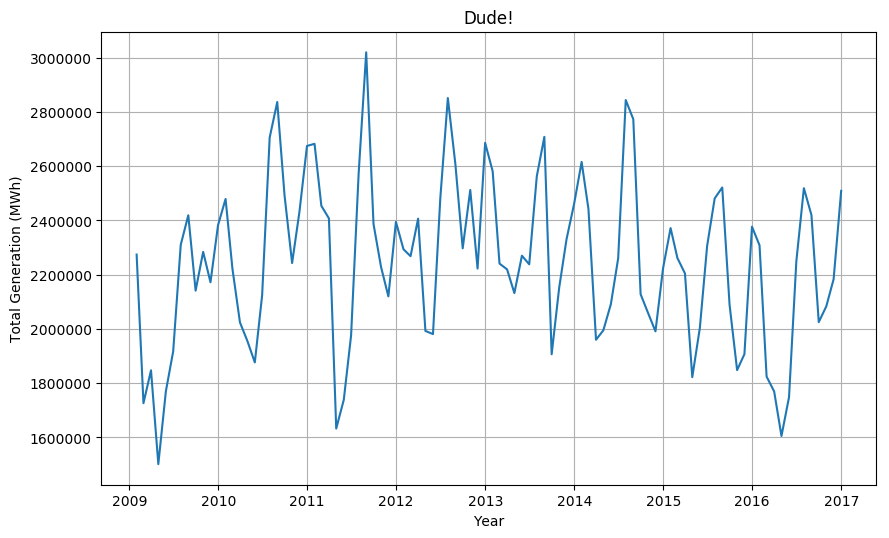

In [10]:
plot_genmix(gf_df)